In [1]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import zipfile
import io
import json
from pandas.io.json import json_normalize
import numpy as np
import datetime
try:
    from pandas import json_normalize
except ImportError:
    from pandas.io.json import json_normalize
import OpenDartReader
from bs4 import BeautifulSoup
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format

In [2]:
'''
고유번호 수집함수

기업고유번호와 종목코드가 매칭된 기준 데이터
'''
def opendart_corp_codes(api_key):

    #전체 고유번호 구하기
    url = 'https://opendart.fss.or.kr/api/corpCode.xml'
    params = { 'crtfc_key': api_key, }

    r = requests.get(url, params=params)
    try:
        tree = ET.XML(r.content)
        status = tree.find('status').text
        message = tree.find('message').text
        if status != '000':
            raise ValueError({'status': status, 'message': message})
    except ET.ParseError as e:
        pass

    zf = zipfile.ZipFile(io.BytesIO(r.content))
    xml_data = zf.read('CORPCODE.xml')

    tree = ET.XML(xml_data)
    all_records = []

    element = tree.findall('list')
    for i, child in enumerate(element):
        record = {}
        for i, subchild in enumerate(child):
            record[subchild.tag] = subchild.text
        all_records.append(record)

    corp_codes = pd.DataFrame(all_records)
    
    return corp_codes

In [3]:
'''
종목코드를 고유번호로 변환
'''
def change_stock_code(corp_codes, stock_code):
    # 종목코드와 매칭되는 고유번호 구하기
    df = corp_codes[corp_codes['stock_code'] == stock_code]
    if df.empty:
        pass
    else:
        corp_code = df.iloc[0]['corp_code']
        
    return corp_code

In [4]:
'''
opendart에 재무제표 요청함수

모든 재무제표를 크롤링 (주요계정, 요약재무제표가 아님)
'''
def opendart_finance(api_key, corp_code, bsns_year, reprt_code, fs_div):

    url = 'https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json'
    params = {
        'crtfc_key': api_key, 
        'corp_code': corp_code,
        'bsns_year': bsns_year,   # 사업년도
        'reprt_code': reprt_code, # "11011": 사업보고서
        'fs_div': fs_div
    }

    r = requests.get(url, params=params)
    jo = json.loads(r.text)
    if jo['status'] == '013':  
        df = pd.DataFrame()
        pass
    else:   
        df = json_normalize(jo, 'list')  
    
    return df

In [5]:
'''
계정 정의
'''
def account_define(account_name):
    account_id_define = {
        '매출액' : ['ifrs_Revenue','',['매출액','수익(매출액)','영업수익', '매출','수익(매출과지분법손익)',
                    '매출과지분법손익(영업수익)','I. 영업수익','I.영업수익','Ⅰ.영업수익', 'Ⅰ. 매출액',
                    'Ⅰ. 매  출  액','수익','계속영업 매출액', 'Ⅰ.매출액', '매출액(영업수익)',
                    '영업수익(매출액)','매출액(수익)','수익 (매출액)', '매출및지분법손익','매출및 지분법손익',
                    '매출 및 지분법손익', '매출 및 지분법 손익','매출액 및 지분법손익','Ⅰ.매출', 'I.매출액',
                    'I.  매출액','수익(순매출액)','매 출 액','I. 매출액','Ⅰ.매출액(주석3)',
                    '매출액(주석3)','매출액(주석3.23)', 'Ⅰ.매출액(주석3.23)', 'I.매출액(주석3.23)', 'Ⅰ.매출액(주석3.24)',
                    '영업 수익','매출액(매출액)', '매출액(주석4,22,31)', 'I. 매출', '매출액(주석2,23,31,39)',
                    '매출액(주석23,31)','고객과의 계약에서 생기는 수익', 'Ⅰ.수익(매출액)','매  출 액', '매출액(주5)',
                    '매출액.', 'I.매출','Ⅰ. 영업수익'],'CIS','IS'],

        '매출총이익':['ifrs_GrossProfit', '',['매출총이익', 'Ⅲ. 매출총이익','Ⅲ. 매출총이익(금융업영업이익)','매출총이익(손실)',
                     'Ⅲ.매출총이익', '매출총손익','매출 총이익', 'III.매출총이익', '매출총손실', 'III. 매출총이익(손실)', '매출 총이익(손실)',
                     'III. 매출총이익', '영업총이익', '매출총이익(영업수익)', 'Ⅲ. 매출총이익(손실)', '매출이익', '용역매출',
                     '영업수익','영업수익(매출)','영업손실','영업수익(매출액)','영업이익'],'CIS','IS'],  

        '영업이익':['dart_OperatingIncomeLoss','',['영업이익(손실)','영업이익','영업손익','III. 영업이익(손실)','III.영업이익',
                    'Ⅲ.영업이익(손실)','Ⅲ.영업이익','Ⅴ. 영업이익(손실)','V. 영업이익','영업손실','Ⅴ.영업이익','IV.영업이익(손실)',
                    'IV.영업이익', 'Ⅳ.영업이익','V.영업이익','V. 영업손익', 'VI.영업이익(손실)','정상영업손익','Ⅳ. 영업이익(손실)',
                    'III. 영업이익','Ⅴ. 영업이익','V. 영업이익(손실)','IV. 영업이익','V.영업이익(손실)','IV. 영업이익(손실)','반기영업이익',
                    '영업이익 (손실)','Ⅳ. 영업이익','Ⅲ. 영업이익(손실)', '영업손실(이익)','IV.영업손익', 'Ⅳ.영업이익(손실)', 'Ⅴ.영업이익(손실)',
                    '영업이익(비용)'],'CIS','IS'],

        '당기순이익':['ifrs_ProfitLoss','',['당기순이익(손실)','분기순이익(손실)','반기순이익','분기순이익','당기순이익','반기순이익(손실)',
                    '-당기순이익(손실)','당(분)기순이익','당(반)기순이익','당기순손익','V. 당기순이익(손실)','ⅩⅠ. 당기순이익(손실)','반기순손실',
                    '당기순손실','분기순손실','분기순이익(순손실)','당기순이익(순손실)','당분기순이익(손실)','당반기순이익(손실)','계속영업당기순이익(손실)',
                    'Ⅹ.당기순이익(손실)','XII.당기순이익(손실)','XIII.당기순이익(손실)','분기순손익','반기순손익','VI. 당기순이익(손실)',
                    '당3분기순이익','당1분기순이익','3분기 순이익','3분기순이익','당기순이익(순실)','당기순손실의 귀속','순이익(손실)',
                    '당기 순이익','연결당기순이익','연결분기(당기)순이익','연결반기(당기)순이익','연결반기순이익','연결분기순이익','Ⅶ.당기순이익',
                    '당(분)기순이익(손실)','당(반)기순이익(손실)','VIII.당기순이익(손실)','VIII.당기순이익','VIII.반기순이익','당기의 순이익',
                    '계속사업순이익(손실)','총포괄손익','분기기순이익(손실)','연결분기순이익(손실)','연결당기순이익(손실)','당기총포괄손실',
                    'Ⅰ.당기순이익(손실)', 'VIII. 분기순이익', 'VIII. 반기순이익', '연결반기순이익(손실)', 'I.당기순이익(손실)', '당기연결순손익',
                    '당기순손익(손실)','Ⅷ. 당기순이익(손실)','법인세 차감 후 반기순이익(손실)','해외사업환산손익','분(당)기순이익(손실)',
                    '반(당)기순이익(손실)','당기(전기)순이익(손실)', '당기연결순이익','총포괄순이익(손실)','연결계속사업당기순이익(손실)',
                    '포괄손익','1. 당기순이익(손실)', 'VIII. 당기순이익(손실)','당분기순이익','VIII. 당기순이익','Ⅶ.당기순이익(손실)',
                    'XⅡ.당기순이익','XII.당기순이익','VII.당기순이익','Ⅶ.반기순이익','당기(분기)순이익(손실)','당기(반기)순이익(손실)',
                    'VII. 반기순이익(손실)','VII. 당기순이익(손실)','XIII. 당기순이익(손실)','분(반)기순이익(손실)','Ⅵ. 당기순이익',
                    'Ⅴ. 당기순이익','XII. 당기순이익', '분기분이익', '당기손익으로 재분류되지 않는 기타포괄손익','당기기순이익','당기순이익 (손실)',
                    '계속영업이익','계속영업 당기순이익','Ⅵ. 당기순이익(손실)','Ⅰ.당기순이익','XI. 당기순이익(손실)','VI.당기순이익(손실)',
                    'IX. 당기순이익(손실)','당기연결손실','총포괄손익 계','당반기순이익','Ⅶ. 당기순이익(손실)','V. 분기순이익','V. 당기순이익',
                    'V. 반기순이익','반기연결순이익(손실)','포괄손익-당기순이익(손실)','Ⅶ. 당기순이익','Ⅶ. 반기순이익','VII. 당기순이익',
                    'VII. 반기순이익','VII. 분기순이익','IX.당기순이익(손실)','Ⅵ.당기순이익(손실)','연결 당기순이익','VII.당기순이익(손실)',
                    'Ⅸ. 당기순이익','XI.당기순이익(손실)','당기순이익(연결)','분기총포괄손익(손실)','당기연결순이익(손실)','VI.당기순손익',
                    '당기순이익(손실):','3분기순이익(손실)','1분기순이익(손실)','분기(당기)순이익(손실)','당기순손실(이익)','X. 당기순이익(손실)',
                    'X. 당반기순이익(손실)','분순이익(손실)','XII.반기순이익(손실)','연결당기순손실','당(분)기순손실','Ⅸ. 당기순이익(손실)',
                    '당기(분기)순이익','Ⅶ. 반기순이익(손실)','반기순손익(손실)','VIII. 반기순이익(손실)','당순이익(손실)','5.당기순이익',
                    '5. 당기순이익','XⅡ.당기순이익(손실)','Ⅶ.반기순이익(손실)','- 당기순이익(손실)','당기순이익과 연결포괄이익','법인순이익과 연결포괄이익',
                    '연결포괄이익','연결당반기순이익(손실)','연결당분기순이익(손실)','연결당기순(손)익','연결반기순(손)익','연결당기순이익 및 총포괄이익',
                    '총포괄이익','당기순이익 및 포괄이익','분기(당기)순이익','반기(당기)순이익'],'CIS','IS'],
        '자산총계':['ifrs_Assets', '',['자산총계','자  산  총  계','자산 총계','자    산    총    계','자 산 총 계','자  산  계',
                    '자산합계'],'BS','BS'],

        '자본총계':['ifrs_Equity', '',['자본총계','자  본  계','자본계','기말자본','반기말자본','IV. 기말자본','IV.기말자본','당분기말','당반기말','자본 총계',
                    '반기말잔액','분기말잔액','기말','반기말','분기말 자본','자본총계1','분기말자본','당분기말 자본','기말 자본','당반기말자본','분기말','당기말자본',
                    'III.기말자본','기말잔액','당기말','전분기말자본','자    본    총    계','당분기말자본','자  본  총  계','기말금액','2019.03.31(당분기말)',
                    'Ⅲ.기말자본','자 본 총 계','Ⅳ.기말자본', 'V.기말자본','당분기말(2019년9월30일)잔액','당기말(2019년12월31일)잔액',
                    '당분기말(2020년3월31일)잔액','당반기말(2020년6월30일)잔액','자본합계', '3분기말자본','1분기말자본','자기주식의 취득',
                    '2015.12.31 기말자본','IV.당(전)기말','반기말 자본','반기자본','자본에 직접 반영된 소유주와의 거래','2015.12.31(당기말)',
                    '기말자본 잔액','2017년 9월 30일 (분기말)','(당기말)','(당분기말)','(당반기말)','2018.9.30(당분기말)', '기   말','총계', 
                    '전기말','자본의조정',],'BS','BS'],

        '부채총계':['ifrs_Liabilities', '',['부채총계', '부  채  총  계', '부채 총계', '부    채    총    계', '부 채 총 계',
                    '부  채  계'],'BS','BS'],
        
        '매출채권':['ifrs_TradeAndOtherCurrentReceivables', '',['매출채권 및 기타채권','매출채권 및 기타유동채권','매출채권','매출채권및기타채권',
                    '기타유동채권','기타채권','미수금및기타수취채권','기타수취채권','(3) 매출채권 및 기타유동채권','기타수치채권',
                    '매출채권및대출채권','2.매출채권','3.기타 수취 채권','4.기타 수취 채권','매출채권 및 기타수취채권','매출채권및기타수취채권',
                    '매출채권및기타유동채권','3.매출채권과 기타채권','3.매출채권 및 기타유동채권','단기기타채권','미수금및기타채권',
                    '매출채권.','매출채권 및 기타금융자산','매출채권 및 수취채권','단기매출채권','매출채권및상각후원가측정금융자산',
                    '대여금및기타수취채권','단기대여금 및 수취채권','단기대여금및수취채권','2)매출채권및기타채권','단기기타수취채권',
                    '매출채권 및 기타상각후원가측정금융자산','매출채권및기타상각후원가측정금융자산', '4. 매출채권','대여금및수취채권',
                    '대여금 및 수취채권','수취채권','매출채권및단기기타채권','기타유동수취채권','대여금및수취채권(유동)','대여금 및 수취채권(유동)',
                    '매출채권 및 기타','5. 매출채권','매출채권및 기타채권','2. 매출채권 및 기타유동채권','매출채권 및 대출채권',
                    '2.매출채권및기타채권','(3)매출채권','(3)매출채권(주석3.5.12)','⑶ 매출채권(주석3.5.12)','매출채권(주석3.5.12.22.28)',
                    '(3)매출채권(주석3.5.12.22.28)','3.매출채권(주석3.5.13.23.29)','매출채권 및 유동기타채권','매출채권및유동기타채권',
                    '매출채권 및 기타금융채권','매출채권 및기타채권','당기손익인식금융자산','기타단기수취채권','3. 매출채권 및 기타유동채권',
                    '매출채권 및 기타단기채권','매출채권 및 기타상각후금융자산','기타채권(유동)','매출채권및기타채권(주석6,30,31)',
                    '유동매출채권 및 기타채권','3. 매출채권및기타채권','3. 매출채권및기타금융자산','매출채권 및 기타유동자산','4. 매출채권및기타채권',
                    '매출채권(주석2,6,12,19,23)','매출채권(주석2,6,12,19,23,27)','매출채권(주석6,12,19,23)','4. 매출채권 및 기타유동채권',
                    '매출채권 및 유동채권','매출채권외수취채권','미수금 및 기타수취채권','매출채권 및 상각후원가측정금융자산(유동)',
                    '매출채권 및 금융리스채권','단기금융자산','매출채권과기타수취채권','매출채권 및 기타채','매출채권 및 기타유동금융자산',
                    '4.매출채권','3.매출채권','미수금 및 기타채권','매출채권 및 상각후원가측정금융자산','유동성보증금','매출채권(주4,6,9)',
                    '매출채권기타채권','기타수취채권(유동)','매출채권 및 계약자산','유동성장기매출채권','유동성기타채권', '유동성 기타채권',
                    '매출채권및기타채권(유동)','기타수채권','매출채권 및 기타 채권','미수금','기타금융채권','기타금융자산', '당좌자산', 
                    '미수수익', '3. 미수수익'],'BS','BS'],
        

        '영업활동으로인한현금흐름':['ifrs_CashFlowsFromUsedInOperatingActivities', '',['영업활동현금흐름','영업활동으로인한현금흐름','Ⅰ.영업활동으로 인한 현금흐름',
                    '영업활동으로 인한 현금흐름','영업활동에서 창출된 현금흐름', 'I. 영업활동으로인한현금흐름','I. 영업활동으로 인한 현금흐름',
                    'I.영업활동으로 인한 현금흐름', 'Ⅰ. 영업에서 창출된 현금','Ⅰ.영업활동현금흐름', 'Ⅰ. 영업에서 창출된 현금흐름',
                    'Ⅰ. 영업활동현금흐름', 'I. 영업활동현금흐름', '영업활동 현금흐름', 'Ⅰ. 영업활동으로 인한 현금흐름', '영업활동으로인한 현금흐름',
                    'I.영업활동현금흐름', '영업활동으로 인한 순현금흐름', '영업활동으로인한순현금흐름', '영업으로인한 현금흐름', 'Ⅰ. 영업활동 현금흐름',
                    '영업활으로 인한 현금흐름', '영업활동으로 인한현금흐름', '1. 영업활동현금흐름', '영업활동으로인현금흐름', '영업활동으로 창출된 현금흐름',
                    '영업활동으로부터의 현금흐름', 'I.영업활동으로인한현금흐름', '영업활동으로 인한 현금 흐름', '1.영업활동으로 인한 현금흐름',
                    '1.영업활동현금흐름','영업활동으로부터 창출된 현금흐름','영업에서 창출된 현금흐름','영업활동현금흐름(주석33)','I. 영업활동 현금흐름',
                    '영업에서창출된현금흐름','I.영업활동 현금흐름','영업에서 사용된 현금흐름','l.영업활동현금흐름','영업으로 인한 현금흐름',
                    '영업활동순현금흐름','Ⅰ.영업활동으로 인한 현금','영업활동으로 인한 현금흐름1','Ⅰ.영업으로 인한 현금흐름',
                    '영업활동 순현금흐름', '영업활동으로부터 발생한 현금흐름', '영업활동으로 인한 순현금흐름액','계속영업'],'CF','CF'],

                }


    account_id_list = account_id_define[account_name]

    return account_id_list

In [6]:
'''
재무비율 정의 함수
'''
def rateoffinance_define(account_names,rate_name_to):
    rate_define = {
        '부채비율' : [['부채총계'],['자본총계'],'200%이하,400%이상',None,None,200,400,'안정성비율','+'],
        '유동부채비율' : [['유동부채'],['자본총계'],'100%이하,200%이상',None,None,100,200,'안정성비율','+'],
        '비유동부채비율' : [['비유동부채'],['자본총계'],'100%이하,200%이상',None,None,100,200,'안정성비율','+'],
        '자기자본비율' : [['자본총계'],['자산총계'],'30%이상,20%이하',30,20,None,None,'안정성비율','+'],
        '당좌비율' : [['유동자산','재고자산'],['유동부채'], '100%이상,50%이하',100,50,None,None,'안정성비율','-'],
        '유동비율' : [['유동자산'],['유동부채'], '150%이상,100%이하',150,100,None,None,'안정성비율','+'],
        '비유동비율' : [['비유동자산'],['자본총계'], '100%이하,150%이상',None,None,100,150,'안정성비율','+'],
        '비유동장기적합률' : [['비유동자산'],['비유동부채','자본총계'], '100%이하,150%이상',None,None,100,150,'안정성비율','+'],
        '매출채권/매입채무비율' : [['매출채권'],['매입채무'], '300%이하,600%이상',None,None,300,600,'안정성비율','+'],
        '매입채무/재고자산비율' : [['매입채무'],['재고자산'], '100%이하,200%이상',None,None,100,200,'안정성비율','+'],
        '순운전자본/총자본비율' : [['유동자산','유동부채'],['자본총계'], '30%이상,10%이하',30,10,None,None,'안정성비율','-'],
        '차입금의존도' : [['단기차입금','유동성장기차입금','장기차입금','사채'],['자산총계'], '30%이하,60%이상',None,None,30,60,'안정성비율','+'],


        '매출액증가율' : [['매출액'],['매출액'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],       
        '영업이익증가율' : [['영업이익'],['영업이익'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],            
        '순이익증가율' : [['당기순이익'],['당기순이익'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],  
        '매출총이익증가율' : [['매출총이익'],['매출총이익'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],          
        '총자산증가율' : [['자산총계'],['자산총계'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],   
        '유형자산증가율' : [['유형자산'],['유형자산'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],   
        '자기자본증가율' : [['자본총계'],['자본총계'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'],   
        '타인자본증가율' : [['부채총계'],['부채총계'], '20%이상,10%이하',20,10,None,None,'성장성비율','+'], 

        '총자산회전율' : [['매출액'],['자산총계'], '1.5회이상,1회이하',1.5,1,None,None,'활동성비율','+'],   
        '총부채회전율' : [['매출액'],['부채총계'], '3회이상,2회이하',3,2,None,None,'활동성비율','+'],  
        '총자본회전율' : [['매출액'],['자본총계'], '3회이상,2회이하',3,2,None,None,'활동성비율','+'],
        '유형자산회전율' : [['매출액'],['유형자산'], '3회이상,2회이하',3,2,None,None,'활동성비율','+'],
        '재고자산회전율' : [['매출액'],['재고자산'], '6회이상,4회이하',6,4,None,None,'활동성비율','+'],
        '매출채권회전율' : [['매출액'],['매출채권'], '6회이상,4회이하',6,4,None,None,'활동성비율','+'],
        '매입채무회전율' : [['매출액'],['매입채무'], '8회이상,6회이하',8,6,None,None,'활동성비율','+'],   

        '매출액총이익율' : [['매출총이익'],['매출액'], '30%이상,20%이하',30,20,None,None,'수익성비율','+'],  
        '매출액영업이익율' : [['영업이익'],['매출액'], '20%이상,10%이하',20,10,None,None,'수익성비율','+'],  
        '매출액순이익율' : [['당기순이익'],['매출액'], '5%이상,2%이하',5,2,None,None,'수익성비율','+'],  
        'ROA' : [['당기순이익'],['자산총계'], '7%이상,2%이하',10,5,None,None,'수익성비율','+'],          
        'ROE' : [['당기순이익'],['자본총계'], '10%이상,5%이하',10,5,None,None,'수익성비율','+'],  

    }
    # 계정명과 일치여부를 확인하기 위해 위의 딕셔너리를 데이터프레임에 넣고 조건값을 분리한다.
    rate_name = pd.DataFrame(rate_define)
    rate_name = rate_name.T
    rate_name = rate_name.reset_index()
    rate_name.columns = ['재무비율','계정명_a', '계정명_b', '표준비율','표준이상_a','표준이하_a','표준이상_b','표준이하_b', '재무비율분류','비고']
    lists_a=rate_name['계정명_a'].to_list()
    lists_b=rate_name['계정명_b'].to_list()

    count_a = []
    count_b = []
    lists_a_0 = []
    lists_a_1 = []
    lists_a_2 = []
    lists_a_3 = []
    lists_b_0 = []
    lists_b_1 = []
    lists_b_2 = []
    lists_b_3 = []

    for i,j in zip(lists_a,lists_b):
        count_a.append(len(i))
        count_b.append(len(j))


        try:
            lists_a_0.append(i[0])
        except IndexError:
            lists_a_0.append(None)

        try:
            lists_a_1.append(i[1])
        except IndexError:
            lists_a_1.append(None)


        try:
            lists_a_2.append(i[2])
        except IndexError:
            lists_a_2.append(None)

        try:
            lists_a_3.append(i[3])
        except IndexError:
            lists_a_3.append(None)

        try:
            lists_b_0.append(j[0])
        except IndexError:
            lists_b_0.append(None)

        try:
            lists_b_1.append(j[1])
        except IndexError:
            lists_b_1.append(None)


        try:
            lists_b_2.append(j[2])
        except IndexError:
            lists_b_2.append(None)

        try:
            lists_b_3.append(j[3])
        except IndexError:
            lists_b_3.append(None)



    rate_name['분자개수'] = count_a
    rate_name['분모개수'] = count_b 
    rate_name['분자조건1'] = lists_a_0
    rate_name['분자조건2'] = lists_a_1
    rate_name['분자조건3'] = lists_a_2
    rate_name['분자조건4'] = lists_a_3
    rate_name['분모조건1'] = lists_b_0  
    rate_name['분모조건2'] = lists_b_1   
    rate_name['분모조건3'] = lists_b_2    
    rate_name['분모조건4'] = lists_b_3  






    if account_names == None:
        rate_names = None
        rate_accounts = None

    else:
        # 계정명과 조건값 일치여부 확인
        for account_name in account_names:
            rate_name.loc[rate_name['분자조건1'] == account_name, '분자1_일치' ] = 1
            rate_name.loc[rate_name['분자조건2'] == account_name, '분자2_일치' ] = 1
            rate_name.loc[rate_name['분자조건3'] == account_name, '분자3_일치' ] = 1
            rate_name.loc[rate_name['분자조건4'] == account_name, '분자4_일치' ] = 1
            rate_name.loc[rate_name['분모조건1'] == account_name, '분모1_일치' ] = 1
            rate_name.loc[rate_name['분모조건2'] == account_name, '분모2_일치' ] = 1
            rate_name.loc[rate_name['분모조건3'] == account_name, '분모3_일치' ] = 1
            rate_name.loc[rate_name['분모조건4'] == account_name, '분모4_일치' ] = 1


        # 일치 개수 확인
        rate_name[rate_name.loc[:,rate_name.columns.str.contains('일치', case=True)].columns] = rate_name[rate_name.loc[:,rate_name.columns.str.contains('일치', case=True)].columns].fillna(0)
        rate_name['분자최종'] =  rate_name['분자개수'] == rate_name['분자1_일치']+rate_name['분자2_일치']+rate_name['분자3_일치']+rate_name['분자4_일치']
        rate_name['분모최종'] =  rate_name['분모개수'] == rate_name['분모1_일치']+rate_name['분모2_일치']+rate_name['분모3_일치']+rate_name['분모4_일치']


        # 최종 재무비율 계산이 가능한 재무비율명 찾기
        final_names = rate_name.loc[(rate_name['분자최종'] == True)&(rate_name['분모최종'] == True), '재무비율'].to_list()


        rate_accounts = [] 
        for final_name in final_names:
            rate_accounts.append(rate_define[final_name])

        rate_names = final_names






    if rate_name_to == None:
        cal_intems = None
    else:
        cal_intems = rate_define[rate_name_to]

    return rate_names, rate_accounts, cal_intems

In [7]:
'''
계정 일반화 함수

open dart에 재무제표를 요청해 수집한 뒤 계정과목을 일반화.
다수의 기업을 동시에 분석할 때 도움.
'''
# 계정일반화
def opendart_account_clean(finance_df, symbol, account_names):
 
    
    finance_df['구분'] = finance_df['bsns_year'] + finance_df['reprt_code'].replace('11013','/1Q').replace('11012','/2Q').replace('11014','/3Q').replace('11011','/4Q')
    finance_df['계정구분'] = finance_df['연결구분'] +'_'+ finance_df['account_nm']
    finance_df['종목코드'] = symbol
    finance_df.rename(columns = {'rcept_no' : '접수번호', 'reprt_code' : '보고서코드','bsns_year' : '사업연도','corp_code' : '고유번호',
                                'sj_div' : '재무제표구분','sj_nm': '재무제표명','account_id': '계정ID', 'account_nm':'계정명',
                                'account_detail':'계정상세','thstrm_nm' : '당기명', 'thstrm_amount' : '당기금액', 'thstrm_add_amount':'당기누적금액',
                                'frmtrm_nm' : '전기명', 'frmtrm_amount':'전기금액','frmtrm_q_nm':'전기명(분/반기)','frmtrm_q_amount':'전기금액(분/반기)',
                                'frmtrm_add_amount':'전기누적금액','bfefrmtrm_nm':'전전기명','bfefrmtrm_amount':'전전기금액','ord':'계정과목 정렬순서'
                                }, inplace = True)
    finance_df = finance_df.set_index('계정구분')
    finance_df = finance_df.reset_index('계정구분')
    finance_df = finance_df.set_index('연결구분')
    finance_df = finance_df.reset_index('연결구분')
    finance_df = finance_df.set_index('종목코드')
    finance_df = finance_df.reset_index('종목코드')
    finance_df = finance_df.set_index('구분')
    finance_df = finance_df.reset_index('구분')   

    
    
    # 빈변수 준비
    except_lists = []
    k_accounts = []

    opendart_finance_final = pd.DataFrame()

    base_data = finance_df.copy()

    if base_data.empty:
        pass
    else:
        base_data['계정ID'] = base_data['계정ID'].str.replace('-full','')
        base_data['계정명'] = base_data['계정명'].str.replace(' ','')
        base_data['계정명'] = base_data['계정명']
        base_total = pd.DataFrame()



        base_data['임시구분'] =  base_data['연결구분'] + '_'+ base_data['구분']
        base_data['임시구분'] = base_data['임시구분'].str.replace(' ','')
        date_divs = base_data['임시구분'].unique()


        for account_name in account_names:
            account_id = account_define(account_name)
            data = base_data.loc[(base_data['재무제표구분'] == account_id[-1])|(base_data['재무제표구분'] == account_id[-2])]

            account_re1 = []
            check_lists = data.loc[data['재무제표구분'] == account_id[-1],'계정명'].unique()
            for account in account_id[2]:
                if account in check_lists:
                    account_re1.append(account)

            account_re2 = []
            check_lists = data.loc[data['재무제표구분'] == account_id[-2],'계정명'].unique()
            for account in account_id[2]:
                if account in check_lists:
                    account_re2.append(account)                          

            for i in date_divs:                
                base_data_first_account1 = data.loc[(data['임시구분'] == i)&(data['계정ID'] == account_id[0])&(data['재무제표구분'] == account_id[-1])].copy()
                if base_data_first_account1.empty:
                    base_data_first_account2 = data.loc[(data['임시구분'] == i)&(data['계정ID'] == account_id[0])&(data['재무제표구분'] == account_id[-2])].copy()     
                    if base_data_first_account2.empty:
                        base_data_second_account1 = data.loc[(data['임시구분'] == i)&(data['계정ID'] == account_id[1])&(data['재무제표구분'] == account_id[-1])].copy()                       
                        if base_data_second_account1.empty:
                            base_data_second_account2 = data.loc[(data['임시구분'] == i)&(data['계정ID'] == account_id[1])&(data['재무제표구분'] == account_id[-2])].copy()
                            if base_data_second_account2.empty:
                                if len(account_re1) != 0:
                                    for account in account_re1:
                                        base_data_third_account1 = data.loc[(data['임시구분'] == i)&(data['계정명'] == account)&(data['재무제표구분'] == account_id[-1])].copy()
                                        if base_data_third_account1.empty:
                                            for account in account_re2:
                                                base_data_third_account2 = data.loc[(data['임시구분'] == i)&(data['계정명'] == account)&(data['재무제표구분'] == account_id[-2])].copy()
                                                if base_data_third_account2.empty:
                                                    pass
                                                else:
                                                    base_data_third_account2['확정계정'] = account_name
                                                    base_total = base_total.append(base_data_third_account2)  
                                                    break      
                       
                                else:
                                    for account in account_re2:
                                        base_data_third_account2 = data.loc[(data['임시구분'] == i)&(data['계정명'] == account)&(data['재무제표구분'] == account_id[-2])].copy()
                                        if base_data_third_account2.empty:
                                            pass
                                        else:
                                            base_data_third_account2['확정계정'] = account_name
                                            base_total = base_total.append(base_data_third_account2)  
                                            break                                                   
                            else:
                                base_data_second_account2['확정계정'] = account_name
                                base_total = base_total.append(base_data_second_account2)                                                  
                        else:
                            base_data_second_account1['확정계정'] = account_name
                            base_total = base_total.append(base_data_second_account1)    
                    else:
                        base_data_first_account2['확정계정'] = account_name
                        base_total = base_total.append(base_data_first_account2)  
                else:
                    base_data_first_account1['확정계정'] = account_name
                    base_total = base_total.append(base_data_first_account1)      


        # 중복제거           
        base_total = base_total.drop_duplicates(['구분','임시구분','당기금액','전기금액','확정계정']) 


    return base_total

In [8]:
'''
데이터 클리닝 (데이터프레임 재구조화)

세로로 이어지는 계정과목과 금액을 분기별로 보기좋게 바꾸기.
'''
# 데이터 클리닝(프레임변형)
def opendart_clean_data(df):
    if df.empty == True:
        print('--clean_data함수 :재무제표 데이터프레임 없음--')
    else:
        date_divs = df['임시구분'].unique()
        account_names = df['확정계정'].unique()


        createDate = datetime.datetime.now()
        thisYear = createDate.year

        base_columns = []
        for div in ['개별','연결']:
            for year in range(2014,thisYear+1):
                for month in ['1Q','2Q','3Q','4Q']:
                    base_column = div+'_'+str(year)+'/'+month
                    base_columns.append(base_column)

        base_columns.insert(0,'계정구분')
        base_columns.insert(1,'종목코드')
        total_df = pd.DataFrame(data = None, columns = base_columns, index = None )
        #total_df = total_df.set_index('계정구분')
        #print(total_df)


        for account_name in account_names:
            ad_df = df.loc[df['확정계정'] == account_name]
            account_id = account_define(account_name)
            temp_df = pd.DataFrame()
            for num,date_div in enumerate(date_divs):
                div = date_div.split('_')[0]
                date = date_div.split('_')[1]
                year = date.split('/')[0]
                month = date.split('/')[1]
                full_last_year = div+'_'+ str(int(year)-1) + '/' + month
                if account_id[-1] == 'IS':

                    if date_div.split('/')[1] == '4Q':    
                        sort_df = ad_df.loc[ad_df['임시구분'] == date_div, ['확정계정','종목코드','당기금액','전기금액']]
                        sort_df[['당기금액','전기금액']] = sort_df[['당기금액','전기금액']] .apply(pd.to_numeric)/100000000
                        sort_df[['당기금액','전기금액']]  = sort_df[['당기금액','전기금액']] .apply(lambda x:round(x,4))
                        sort_df.columns = ['계정구분','종목코드', date_div, full_last_year]
                        sort_df = sort_df[['계정구분','종목코드',full_last_year, date_div]]  
                        sort_df = sort_df.dropna(axis=1)                               
                        temp_df = temp_df.append(sort_df) 

                    else:
                        sort_df = ad_df.loc[ad_df['임시구분'] == date_div, ['확정계정','종목코드','당기누적금액','전기누적금액']]
                        sort_df[['당기누적금액','전기누적금액']] = sort_df[['당기누적금액','전기누적금액']] .apply(pd.to_numeric)/100000000
                        sort_df[['당기누적금액','전기누적금액']]  = sort_df[['당기누적금액','전기누적금액']] .apply(lambda x:round(x,4))


                        sort_df.columns = ['계정구분','종목코드', date_div, full_last_year]
                        sort_df = sort_df[['계정구분','종목코드',full_last_year, date_div]]  
                        sort_df = sort_df.dropna(axis=1)                               
                        temp_df = temp_df.append(sort_df) 

                else:                    
                    sort_df = ad_df.loc[ad_df['임시구분'] == date_div, ['확정계정','종목코드','당기금액','전기금액']]
                    sort_df[['당기금액','전기금액']] = sort_df[['당기금액','전기금액']] .apply(pd.to_numeric)/100000000
                    sort_df[['당기금액','전기금액']]  = sort_df[['당기금액','전기금액']] .apply(lambda x:round(x,2))
                    sort_df.columns = ['계정구분','종목코드', date_div, full_last_year]
                    sort_df = sort_df[['계정구분','종목코드',full_last_year, date_div]]  
                    sort_df = sort_df.dropna(axis=1)                               
                    temp_df = temp_df.append(sort_df)                         


            temp_df = temp_df.fillna(method='bfill') 
            temp_df = temp_df.fillna(method='ffill') 
            temp_df = temp_df.iloc[0:1,:]


            total_df = total_df.append(temp_df)

        # 컬럼재정렬
        total_df = total_df.set_index('종목코드')
        total_df = total_df.sort_index(axis=1)
        total_df = total_df.reset_index('종목코드')
        total_df = total_df.set_index('계정구분')   

        # 연결재무제표 계정에 데이터가 없을 경우 개별데이터로 채우기
        check_data = total_df.loc[:,total_df.columns.str.contains('연결')].columns.to_list()
        for check_column in check_data:
            total_df.loc[total_df[check_column].isnull(), check_column] = total_df['개별' + '_' + check_column.split('_')[1]]

    return total_df

In [9]:
'''
재무비율 계산함수
'''
###### 재무비율 계산 함수
def opendart_rateoffinance(df,stock_code,account_names):
    if df.empty:
        print('--rateoffinance함수 : {} 재무제표 데이터프레임 없음--'.format(stock_code))
    else:
        total_account = df.copy()


        rate_names,rate_accounts,cal_intems = rateoffinance_define(account_names, None)


        # 계정과목 존재여부 확인
        # 계정과목이 없을 겨우 재무비율을 구할때 에러가 날 수 있다.
        # 따라서 재무비율 산출 직전에 리스트를 정리한다.
        for rate_account in rate_accounts:
            for i in [0,1]:
                for num,account in enumerate(rate_account[i]):
                    try:
                        exist= total_account.loc[account]
                    except KeyError:
                        print('opendart_rateoffinance 함수 인덱스 에러 : {} {} 계정없는것으로 확인됨'.format(stock_code,account))
                        rate_account[i].remove(account)
                        continue

        # 대상컬럼정의
        column_names = total_account.loc[:,total_account.columns.str.contains('/', case=True)].columns



        for rate_name,rate_account in  zip(rate_names,rate_accounts): 

            if rate_account[-2] == '성장성비율':
                total_account.loc['성장성:'+ rate_name+'_(%)'] = None
                for column_name in column_names:
                    date = column_name.split('_')[1]
                    last_year = int(date.split('/')[0])-1
                    full_last_year = column_name.split('_')[0]+'_' + str(last_year)+'/'+column_name.split('/')[1]

                    if full_last_year not in column_names:
                        if total_account.loc[rate_account[0][0],column_name] == 0:
                            pass
                        else:
                            total_account.loc['성장성:'+ rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name] / total_account.loc[rate_account[0][0],column_name] * 100)-100,4)
                    else: 
                        if total_account.loc[rate_account[0][0],column_name] == 0 or total_account.loc[rate_account[0][0],full_last_year] == 0:
                            pass
                        else:           
                            total_account.loc['성장성:'+ rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name] / total_account.loc[rate_account[0][0],full_last_year] * 100)-100,4)    
            # 활동성비율의 경우 연율화가 필요함
            # 손익계산서와 재무상태표상의 기준을 맞추기 위함
            elif rate_account[-2] == '활동성비율':     
                total_account.loc['활동성:'+rate_name+'_(%)'] = None
                for column_name in column_names:
                    date = column_name.split('_')[1]
                    last_year = int(date.split('/')[0])-1
                    full_last_year = column_name.split('_')[0]+'_' + str(last_year)+'/'+column_name.split('/')[1]
                    if full_last_year not in column_names:
                        pass
                    else:
                        if total_account.loc[rate_account[0][0],column_name] == 0:
                            pass
                        else:
                            if total_account.loc[rate_account[0][0],column_name] == 0 or total_account.loc[rate_account[0][0],full_last_year] == 0:
                                pass 
                            else: 
                                if column_name.split('/')[1] == '1Q':
                                    total_account.loc['활동성:'+ rate_name+'_(%)',column_name] =  round((total_account.loc[rate_account[0][0],column_name]*4)/ ((total_account.loc[rate_account[1][0],full_last_year]+total_account.loc[rate_account[1][0],column_name]) / 2),4)
                                if column_name.split('/')[1] == '2Q':
                                    total_account.loc['활동성:'+ rate_name+'_(%)',column_name] =  round((total_account.loc[rate_account[0][0],column_name]*2)/ ((total_account.loc[rate_account[1][0],full_last_year]+total_account.loc[rate_account[1][0],column_name]) / 2),4)
                                if column_name.split('/')[1] == '3Q':
                                    total_account.loc['활동성:'+ rate_name+'_(%)',column_name] =  round((total_account.loc[rate_account[0][0],column_name]*4/3)/ ((total_account.loc[rate_account[1][0],full_last_year]+total_account.loc[rate_account[1][0],column_name]) / 2),4)
                                if column_name.split('/')[1] == '4Q':
                                    total_account.loc['활동성:'+ rate_name+'_(%)',column_name] =  round((total_account.loc[rate_account[0][0],column_name]*1)/ ((total_account.loc[rate_account[1][0],full_last_year]+total_account.loc[rate_account[1][0],column_name]) / 2),4)          


            # 연율화가 필요함
            # 손익계산서와 재무상태표상의 기준을 맞추기 위함
            elif rate_account[-2] == '수익성비율':
                total_account.loc['수익성:'+rate_name+'_(%)'] = None
                for column_name in column_names:

                    if rate_name == 'ROE':
                        date = column_name.split('_')[1]
                        last_year = int(date.split('/')[0])-1
                        full_last_year = column_name.split('_')[0]+'_' + str(last_year)+'/'+column_name.split('/')[1]
                        if full_last_year not in column_names:
                            pass
                        else:
                            if total_account.loc[rate_account[0][0],column_name] == 0 or total_account.loc[rate_account[0][0],full_last_year] == 0:
                                pass 
                            else:                   
                                if column_name.split('/')[1] == '1Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*4) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                                if column_name.split('/')[1] == '2Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*2) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                                if column_name.split('/')[1] == '3Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*4/3) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                                if column_name.split('/')[1] == '4Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*1) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                   
                    elif rate_name == 'ROA':
                        date = column_name.split('_')[1]
                        last_year = int(date.split('/')[0])-1
                        full_last_year = column_name.split('_')[0]+'_' + str(last_year)+'/'+column_name.split('/')[1]
                        if full_last_year not in column_names:
                            pass
                        else:     
                            if total_account.loc[rate_account[0][0],column_name] == 0 or total_account.loc[rate_account[0][0],full_last_year] == 0:
                                pass 
                            else:                   
                                if column_name.split('/')[1] == '1Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*4) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                                if column_name.split('/')[1] == '2Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*2) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                                if column_name.split('/')[1] == '3Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*4/3) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                                if column_name.split('/')[1] == '4Q':
                                    total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name]*1) / ((total_account.loc[rate_account[1][0],full_last_year] + total_account.loc[rate_account[1][0],column_name])/2)* 100,4)
                    else:
                        if total_account.loc[rate_account[0][0],column_name] == 0 or total_account.loc[rate_account[0][0],full_last_year] == 0:
                            pass  
                        else:                           
                            total_account.loc['수익성:'+rate_name+'_(%)',column_name] = round((total_account.loc[rate_account[0][0],column_name] / total_account.loc[rate_account[1][0],column_name] * 100),4)

            else:
                pass

        # 종목코드 채우기
        total_account['종목코드'] = total_account['종목코드'].fillna(method='ffill')


    return total_account

In [10]:
'''
고유번호 수집실행
'''
api_key = '79b151388ac315eb331c7e584683b65849fc22fa'
corp_codes = opendart_corp_codes(api_key)
corp_codes

,corp_code,corp_name,stock_code,modify_date
0,00434003,다코,,20170630
1,00434456,일산약품,,20170630
2,00430964,굿앤엘에스,,20170630
3,00432403,한라판지,,20170630
4,00388953,크레디피아제이십오차유동화전문회사,,20170630
...,...,...,...,...
89101,01560457,삼원개발,,20210506
89102,01556533,에이더블유파트너스,,20210506
89103,01546299,동영와이케이,,20210506
89104,00694605,미디어윌,,20210506


In [11]:
'''
단일기업 분기별 재무제표 수집
'''
##### 변수설정
stock_code = '010950' # 종목코드
corp_code = change_stock_code(corp_codes, stock_code) # 종목코드를 고유번호로 변환
reprt_codes = ['11013','11012','11014','11011'] # 분기별 report code
fs_div = 'CFS' # 연결/개별 구분

##### 전체재무제표 수집
total_df = pd.DataFrame()
for bsns_year in range(2015,2022):  # 연도는 range함수로 설정
    bsns_year = str(bsns_year)
    for reprt_code in reprt_codes:
        df = opendart_finance(api_key, corp_code, bsns_year, reprt_code,fs_div)
        if df.empty:
            pass
        else:
            if fs_div == 'CFS':
                df['연결구분'] = '연결'
            if fs_div == 'OFS':
                df['연결구분'] = '개별'
                
            total_df = total_df.append(df)
            
total_df.tail()

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,...,frmtrm_nm,frmtrm_amount,bfefrmtrm_nm,bfefrmtrm_amount,ord,thstrm_add_amount,연결구분,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
133,20211115000903,11014,2021,00138279,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업의 소유주에게 귀속되는 자본 [member]|이익잉여금...,제 47 기 3분기,...,NaN,NaN,NaN,NaN,12,NaN,연결,제 46 기 3분기,3919235000000,NaN
134,20211115000903,11014,2021,00138279,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업의 소유주에게 귀속되는 자본 [member]|자기주식,제 47 기 3분기,...,NaN,NaN,NaN,NaN,12,NaN,연결,제 46 기 3분기,-1876000000,NaN
135,20211115000903,11014,2021,00138279,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업의 소유주에게 귀속되는 자본 [member]|자본금 [...,제 47 기 3분기,...,NaN,NaN,NaN,NaN,12,NaN,연결,제 46 기 3분기,291512000000,NaN
136,20211115000903,11014,2021,00138279,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업의 소유주에게 귀속되는 자본 [member]|적립금,제 47 기 3분기,...,NaN,NaN,NaN,NaN,12,NaN,연결,제 46 기 3분기,978240000000,NaN
137,20211115000903,11014,2021,00138279,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업의 소유주에게 귀속되는 자본 [member]|주식발행초과금,제 47 기 3분기,...,NaN,NaN,NaN,NaN,12,NaN,연결,제 46 기 3분기,379190000000,NaN


In [12]:
'''
계정일반화 실행
'''
account_names = ['매출액','매출채권','영업활동으로인한현금흐름']
account_clean = opendart_account_clean(total_df, stock_code, account_names)
account_clean.tail()

,구분,종목코드,연결구분,계정구분,접수번호,보고서코드,사업연도,고유번호,재무제표구분,재무제표명,...,전기금액,전전기명,전전기금액,계정과목 정렬순서,당기누적금액,전기명(분/반기),전기금액(분/반기),전기누적금액,임시구분,확정계정
2519,2020/3Q,010950,연결,연결_영업활동현금흐름,20201116000551,11014,2020,00138279,CF,현금흐름표,...,NaN,NaN,NaN,0,NaN,제 45 기 3분기,191321000000,NaN,연결_2020/3Q,영업활동으로인한현금흐름
2654,2020/4Q,010950,연결,연결_영업활동현금흐름,20210322000581,11011,2020,00138279,CF,현금흐름표,...,679447000000,제 44 기,-288185000000,0,NaN,NaN,NaN,NaN,연결_2020/4Q,영업활동으로인한현금흐름
2798,2021/1Q,010950,연결,연결_영업활동현금흐름,20210517000241,11013,2021,00138279,CF,현금흐름표,...,NaN,NaN,NaN,0,NaN,제 46 기 1분기,-783901000000,NaN,연결_2021/1Q,영업활동으로인한현금흐름
2927,2021/2Q,010950,연결,연결_영업활동현금흐름,20210817001777,11012,2021,00138279,CF,현금흐름표,...,NaN,NaN,NaN,0,NaN,제 46 기 반기,545430000000,NaN,연결_2021/2Q,영업활동으로인한현금흐름
3063,2021/3Q,010950,연결,연결_영업활동현금흐름,20211115000903,11014,2021,00138279,CF,현금흐름표,...,NaN,NaN,NaN,0,NaN,제 46 기 3분기,470750000000,NaN,연결_2021/3Q,영업활동으로인한현금흐름


In [13]:
'''
데이터 클리닝 실행
'''
clean_data = opendart_clean_data(account_clean)
clean_data = clean_data.dropna(axis=1)
clean_data.tail()

,종목코드,연결_2014/4Q,연결_2015/1Q,연결_2015/2Q,연결_2015/3Q,연결_2015/4Q,연결_2016/1Q,연결_2016/2Q,연결_2016/3Q,연결_2016/4Q,...,연결_2019/2Q,연결_2019/3Q,연결_2019/4Q,연결_2020/1Q,연결_2020/2Q,연결_2020/3Q,연결_2020/4Q,연결_2021/1Q,연결_2021/2Q,연결_2021/3Q
계정구분,,,,,,,,,,,,,,,,,,,,,
매출액,010950,285575.62,43737.83,95162.90,139429.57,178902.72,34284.20,76267.84,117647.04,163218.43,...,116834.48,179179.35,243941.73,51984.01,86502.22,125494.06,168296.81,53447.86,120558.07,191728.17
매출채권,010950,15240.56,10308.81,10308.81,10308.81,10308.81,9870.02,10682.14,9591.45,11546.08,...,2311.62,2178.04,2647.10,2691.80,1547.90,1555.38,1719.02,1697.04,2070.35,2278.52
영업활동으로인한현금흐름,010950,8792.01,13774.27,15879.70,20127.34,24755.50,4904.23,9513.16,9655.51,17219.91,...,109.32,1938.08,6794.47,-7839.01,5454.30,4707.50,16309.72,5592.34,8905.94,2397.53


In [14]:
'''
재무비율 계산
'''
rateoffinance = opendart_rateoffinance(clean_data,stock_code,account_names)
rateoffinance

,종목코드,연결_2014/4Q,연결_2015/1Q,연결_2015/2Q,연결_2015/3Q,연결_2015/4Q,연결_2016/1Q,연결_2016/2Q,연결_2016/3Q,연결_2016/4Q,...,연결_2019/2Q,연결_2019/3Q,연결_2019/4Q,연결_2020/1Q,연결_2020/2Q,연결_2020/3Q,연결_2020/4Q,연결_2021/1Q,연결_2021/2Q,연결_2021/3Q
계정구분,,,,,,,,,,,,,,,,,,,,,
매출액,010950,285575.62,43737.83,95162.90,139429.57,178902.72,34284.20,76267.84,117647.04,163218.43,...,116834.48,179179.35,243941.73,51984.01,86502.22,125494.06,168296.81,53447.86,120558.07,191728.17
매출채권,010950,15240.56,10308.81,10308.81,10308.81,10308.81,9870.02,10682.14,9591.45,11546.08,...,2311.62,2178.04,2647.10,2691.80,1547.90,1555.38,1719.02,1697.04,2070.35,2278.52
영업활동으로인한현금흐름,010950,8792.01,13774.27,15879.70,20127.34,24755.50,4904.23,9513.16,9655.51,17219.91,...,109.32,1938.08,6794.47,-7839.01,5454.30,4707.50,16309.72,5592.34,8905.94,2397.53
성장성:매출액증가율_(%),010950,0.00,0.00,0.00,0.00,-37.35,-21.61,-19.86,-15.62,-8.77,...,2.36,-3.68,-4.20,-4.20,-25.96,-29.96,-31.01,2.82,39.37,52.78
활동성:매출채권회전율_(%),010950,NaN,NaN,NaN,NaN,14.00,13.59,14.53,15.76,14.94,...,106.63,96.59,107.41,91.39,89.65,89.64,77.09,97.42,133.28,133.36


In [15]:
'''
매출채권회수기간 계산
'''
rateoffinance.loc['매출채권회수기간'] = 365 /rateoffinance.loc['활동성:매출채권회전율_(%)'].apply(pd.to_numeric)
rateoffinance.loc['매출채권회수기간','종목코드'] = None
rateoffinance['종목코드'] = rateoffinance['종목코드'].fillna(method='ffill') 
rateoffinance = rateoffinance.dropna(axis=1)
rateoffinance

,종목코드,연결_2015/4Q,연결_2016/1Q,연결_2016/2Q,연결_2016/3Q,연결_2016/4Q,연결_2017/1Q,연결_2017/2Q,연결_2017/3Q,연결_2017/4Q,...,연결_2019/2Q,연결_2019/3Q,연결_2019/4Q,연결_2020/1Q,연결_2020/2Q,연결_2020/3Q,연결_2020/4Q,연결_2021/1Q,연결_2021/2Q,연결_2021/3Q
계정구분,,,,,,,,,,,,,,,,,,,,,
매출액,010950,178902.72,34284.20,76267.84,117647.04,163218.43,52001.55,98651.59,150770.07,208913.74,...,116834.48,179179.35,243941.73,51984.01,86502.22,125494.06,168296.81,53447.86,120558.07,191728.17
매출채권,010950,10308.81,9870.02,10682.14,9591.45,11546.08,12023.92,12639.77,2914.42,2196.31,...,2311.62,2178.04,2647.10,2691.80,1547.90,1555.38,1719.02,1697.04,2070.35,2278.52
영업활동으로인한현금흐름,010950,24755.50,4904.23,9513.16,9655.51,17219.91,-1935.54,-345.30,5184.28,11432.94,...,109.32,1938.08,6794.47,-7839.01,5454.30,4707.50,16309.72,5592.34,8905.94,2397.53
성장성:매출액증가율_(%),010950,-37.35,-21.61,-19.86,-15.62,-8.77,51.68,29.35,28.15,28.00,...,2.36,-3.68,-4.20,-4.20,-25.96,-29.96,-31.01,2.82,39.37,52.78
활동성:매출채권회전율_(%),010950,14.00,13.59,14.53,15.76,14.94,19.00,16.92,32.15,30.40,...,106.63,96.59,107.41,91.39,89.65,89.64,77.09,97.42,133.28,133.36
매출채권회수기간,010950,26.06,26.85,25.11,23.15,24.44,19.21,21.57,11.35,12.00,...,3.42,3.78,3.40,3.99,4.07,4.07,4.73,3.75,2.74,2.74


<AxesSubplot:>

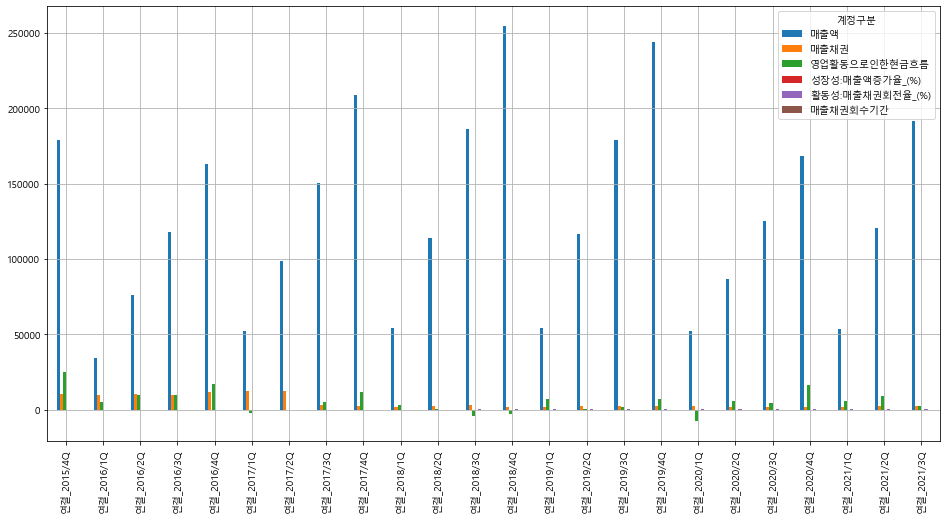

In [16]:
'''
바차트로 결과확인
'''
# 그래프옵션
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['axes.grid'] = True
plt.rc('font', family='Malgun Gothic')

rateoffinance.loc[:,rateoffinance.columns.str.contains('연결')].T.plot(kind='bar')

<AxesSubplot:>

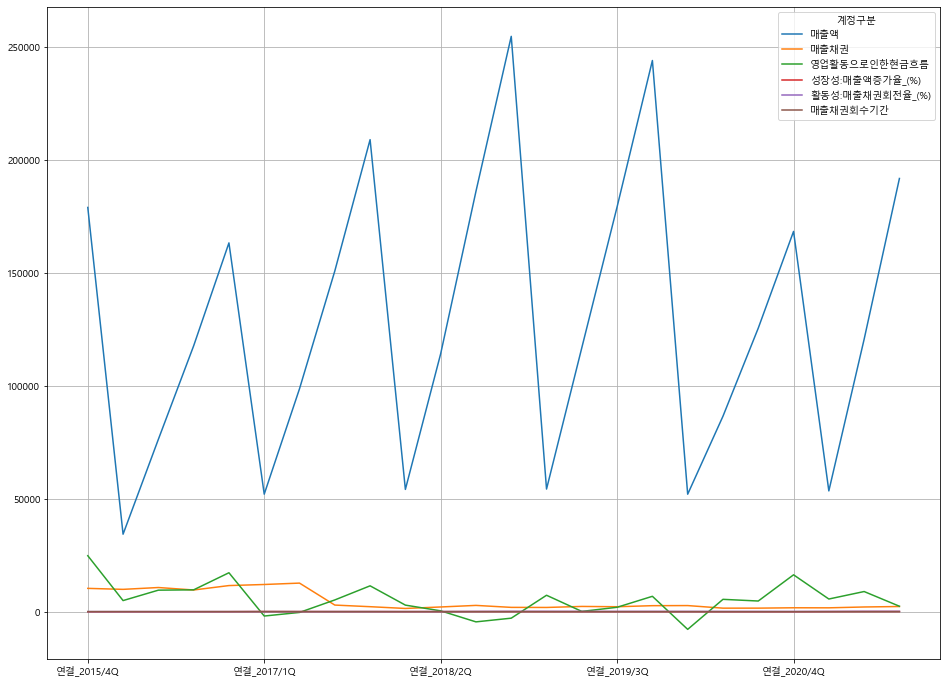

In [17]:
# 그래프옵션
plt.rcParams['figure.figsize'] = (16,12)
plt.rcParams['axes.grid'] = True
plt.rc('font', family='Malgun Gothic')

rateoffinance.loc[:,rateoffinance.columns.str.contains('연결')].T.plot(kind='line')